In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from random import randint, seed, uniform
import numpy as np
import swarms

from constants import PC, MSUN, LSUN, JY, MMOON, MJUP, RJUP, AU, MEARTH, YEAR 

try:
    plt.style.use('paper')
except:
    pass

In [23]:
GPI = pd.read_csv("../csvs/fullGPIsample.csv", index_col=0)
GPI = GPI[~GPI['Distance_distance'].isnull()]
GPI = GPI.reset_index(drop=True)
GPI['Age'] = 0
GPI.tail()
# for i in range(len(GPI['S_Type'])):
#     print(GPI['S_Type'][i][0])

,S_Type,Distance_distance,FLUX_I,FLUX_H,Fe_H_Teff,Class,subtype,Mbol,Lum,Teff,Mass,Age
594,B9V,48.5835,NaN,4.622,10860,B,9,0.570,46.558609,10850.0,2.455,0
595,A7III/IV,67.1100,NaN,5.879,7834,A,7,2.445,8.279422,8000.0,1.595,0
596,F6V,35.3895,6.370,5.787,6255,F,6,3.860,2.249055,6400.0,1.160,0
597,K2V,21.9270,7.194,6.007,0,K,2,5.620,0.444631,4930.0,0.738,0
598,A1V,47.0754,NaN,4.949,9057,A,1,1.440,20.892961,9370.0,2.005,0


In [24]:
def Imag(row):
    star = swarms.Star(L=row['Lum']*LSUN, M=row['Mass']*MSUN, T=row['Teff'], d=row['Distance_distance']*PC)
    return star.Imag

In [25]:
GPI['Imag'] = GPI.apply(Imag, axis=1)
GPI.tail()

,S_Type,Distance_distance,FLUX_I,FLUX_H,Fe_H_Teff,Class,subtype,Mbol,Lum,Teff,Mass,Age,Imag
594,B9V,48.5835,NaN,4.622,10860,B,9,0.570,46.558609,10850.0,2.455,0,4.344432
595,A7III/IV,67.1100,NaN,5.879,7834,A,7,2.445,8.279422,8000.0,1.595,0,6.353499
596,F6V,35.3895,6.370,5.787,6255,F,6,3.860,2.249055,6400.0,1.160,0,6.080366
597,K2V,21.9270,7.194,6.007,0,K,2,5.620,0.444631,4930.0,0.738,0,6.626458
598,A1V,47.0754,NaN,4.949,9057,A,1,1.440,20.892961,9370.0,2.005,0,4.853445


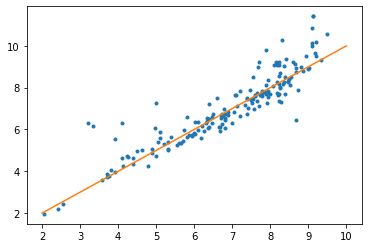

In [26]:
fig, ax = plt.subplots()
ax.plot(GPI['FLUX_I'][~GPI['FLUX_I'].isnull()], GPI['Imag'][~GPI['FLUX_I'].isnull()], '.')
ax.plot(np.linspace(2, 10, 100), np.linspace(2, 10, 100))

BX Ant V 11.45, I 9.3, J 8.7, H 8.2, K 8.0
CD-33 7795 V 11.5, I 9.15, J 7.7, H 7.0, K 6.7
CD-29 8887 V 11.1, I 8.9, J 7.6, H 6.9, K 6.7
CD-34 7390 V 11.1, I 9.038, J 8.43 from literature/simbad. Interpolated Y 8.7 H 7.7 K 7.4

TWA 13 > 4" apart https://www.aanda.org/articles/aa/pdf/2014/03/aa22075-13.pdf table 3
Hen 3-600 1.5" apart https://arxiv.org/pdf/0912.3537.pdf Fig 1

https://iopscience.iop.org/article/10.3847/0004-6256/152/1/3/pdf for TWA 13 J band mag

https://academic.oup.com/mnras/article/469/1/579/3103050 HD 155555C. Hint of IR excess

In [27]:
contrastsep = np.linspace(0, 1.2, 1000)
contrast = np.ones(1000)*1.e-5

# Drawing Planets

Clanton 16 has outer cutoff at 10 AU, with huge positive error bar (+75 or something). Not constrained at all at GPI distances. ALMA (Zhang 18) say semimajor axis distribution consistent with flat in log a (this is actually consistent with Clanton 16. Their best fit said that planet occurrence increased with distance (with outer cutoff at 10 AU), but Fig 14 corner plot shows that at 1 sigma, beta can be 0 (flat in log a) if the outer cutoff is at large distances (what ALMA finds)).

So, model as flat in log a, following Clanton 16 mass distribution. We also want to match the overall occurrence. We can put this in by hand. Set to 0.5 (Zhang 18) between Nep and 13 Mjup. In this case, using their power law, you get about 1% occurrence > 3 M_J, consistent with direct imaging surveys.

In [28]:
Mmin = 15 # Mearth (Nep)
Mmax = 13*318 # Mearth (Jup)
nvals = 1000
# Draw mass from Nep to 13 Mjup according to m^-0.86 Clanton 16
# ignore normalization which goes into occurrence. We assume we draw a planet, just 
# want relative fractions correct
totoccurrence = 0.5
Npts = 1000
alpha = -0.86
ms = np.linspace(Mmin, Mmax, Npts)
pdf = ms**(alpha-1) # dN/dlogM = dN/dM * m, so dN/dM \propto m^(alpha-1)
cumpdf = np.cumsum(pdf)/pdf.sum() * totoccurrence
randv = np.random.uniform(size=nvals)
idxs = np.searchsorted(cumpdf, randv)
masses = ms[[idx for idx in idxs if idx < len(cumpdf)]]

By multiplying the cum pdf by the total occurrence we want, we get the bottom. Now we draw from this distribution by picking a value on the y axis. If we pick a number greater than the occurrence rate, here 0.5, and end up above the line, we miss, and the system has no planet. If we draw a number below, we hit the curve, and we find the corresponding x value as our planetary mass. Last line in cell above deals with all the curve misses in searchsorted, which when that happens returns len(cumpdf) for the index).

Text(0, 0.5, 'Cumulative PDF')

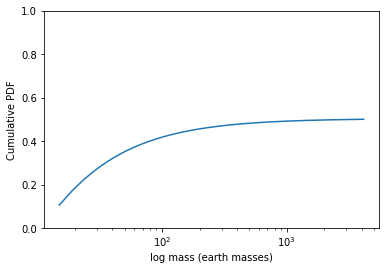

In [29]:
fig, ax = plt.subplots()
ax.plot(ms, cumpdf)
ax.set_ylim([0,1])
ax.set_xscale('log')
ax.set_xlabel('log mass (earth masses)')
ax.set_ylabel('Cumulative PDF')

We drew nvals samples, so calculate the fraction between Nep and 3 MJ

In [30]:
((masses < 900) & (masses > 14.9)).sum()/nvals

0.51100000000000001

Fraction > 3 M_J, should be 1% to be consistent with direct imaging

In [31]:
(masses > 900).sum()/nvals

0.012999999999999999

In log log plot, bins are logarithmic, so delta log M = const = B. Then N = Am^alpha * B, so log N = alpha*m + const = line

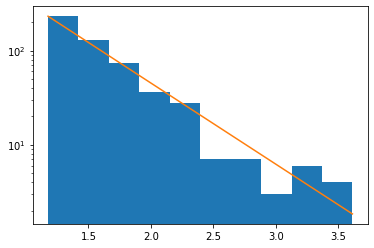

In [32]:
fig, ax = plt.subplots()
hist, edges, patches = ax.hist(np.log10(masses))
ax.plot(edges, 10**(np.log10(hist[0])+(edges-edges[0])*(alpha)))
ax.set_yscale('log')

In linear plot with linear bins, N = Am^(alpha-1) * B, but can't take log of both sides since we said we made a plot with linear bins. N_i = N_0*(m_i/m_0)^(alpha-1)

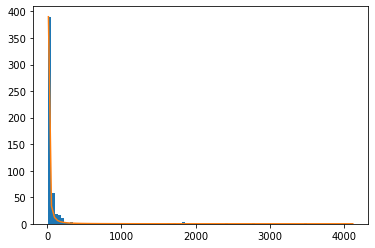

In [33]:
fig, ax = plt.subplots()
hist, edges, patches = ax.hist(masses, bins=100)
ax.plot(edges, hist[0]*(edges/edges[0])**(alpha-1))

In [34]:
seed(0)

def loguniform(minval, maxval):
    return 10**uniform(np.log10(minval), np.log10(maxval))

def draw_star(GPI):
    if isinstance(GPI, pd.Series):
        star = GPI
    else:
        idx = randint(0, GPI.shape[0]-1)
        star = GPI.loc[idx]
    return star['Mass']*MSUN, star['Lum']*LSUN, star['Fe_H_Teff'], star['Distance_distance']*PC, star['Imag'], star['Age']*YEAR, star['S_Type'][0]

def draw_planet(star, age, IWA=0.2, OWA=1.2):
    Mmin = 21 # Mearth (Nep)
    Mmax = 5*318 # Mearth (Jup)
    # Draw mass from Nep to 13 Mjup according to m^-0.86 Clanton 16
    totoccurrence = 1.
    Npts = 1000
    alpha = -0.86
    Q = 0.5 # planet albedo
    ms = np.linspace(Mmin, Mmax, Npts)
    pdf = ms**(alpha-1) # dN/dlogM = dN/dM * m, so dN/dM \propto m^(alpha-1)
    cumpdf = np.cumsum(pdf)/pdf.sum() * totoccurrence
    randv = np.random.uniform()
    idx = np.searchsorted(cumpdf, randv)
    if idx == len(cumpdf):
        return None # didn't draw a planet
    else:
        # draw semimajor axis
        amin = star.d/PC*IWA# AU
        amax = star.d/PC*OWA # AU
        a = loguniform(amin, amax)
        return swarms.Planet(star, M=ms[idx]*MEARTH , R=None, a=a*AU, Q=Q, Z='002', age=age)

def contrast_scat(A, g, Q, a_pl):
    return (A*g*Q) / (np.pi*a_pl**2)

In [38]:
def sample(GPI):
    Mstar, Lstar, Tstar, d_pl, Imag, age, star_type = draw_star(GPI)
    if age == 0:
        age = loguniform(1e7, 1e8) * YEAR
    star = swarms.Star(Lstar, Mstar, Tstar, d=d_pl)
    if 10780000 >= age/YEAR:
        return None, None, None, None, None, None, None
    planet = draw_planet(star, age, IWA=0.2, OWA=10)
   # print(planet.a)
    if planet.a == None:
        return None, None, None, None, None, None, None
    
    Dc = loguniform(1e5, 1e6) # m
    Mtot = loguniform(0.2, 2)*MEARTH #loguniform(1e-4, 1)*Mearth
    rho = 1000 # kg/m^3
    eta = 0.5 # eta
    Q = loguniform(0.05, 0.5) # Q_bd = [0, 0.8]
    g = loguniform(0.2, 0.8) # 0.32 https://arxiv.org/pdf/1709.00417.pdf
    Dt = loguniform(10, 1000)
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    f_vrel = 4/np.pi
    alpha= 1.2
    
    swarm = swarms.CollSwarm(star, planet, M0=M0, Dmax=Dmax, Dt=Dt, eta=eta, Q=Q, g=g, rho=rho,
                             fQ=fQ, Nstr=Nstr, f_vrel=f_vrel, alpha=alpha, age=age)
    CRscatSwarm = swarm.computeCRscat()
    return CRscatSwarm, planet.a/AU, d_pl/PC, Imag, planet.M, star_type, star

In [39]:
%%time
seed(0)
M0 = 1*MEARTH
Nsamples = 600
star_type = []
stars = []
CR, a, d, Imag, Mplt = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CR[i], a[i], d[i], Imag[i], Mplt[i], stype, s = sample(GPI)
    star_type.append(stype)
    stars.append(s)
#print(CR)

CPU times: user 10.6 s, sys: 70 ms, total: 10.7 s
Wall time: 10.7 s


In [40]:
def aopt(Mtot):
    star = star_sampler()
    star.d = 10*PC # dummy value
    age = age_sampler()
    planet = draw_planet(star, age)
    if planet is None:
        return aopt(Mtot) # do it again
    Dc = loguniform(1e5, 1e6) # m
    rho = 1000 # kg/m^3
    eta = 0.5 # eta
    Q = loguniform(0.05, 0.25) # Q_bd = [0, 0.8]
    g = loguniform(0.2, 0.8) # 0.32 https://arxiv.org/pdf/1709.00417.pdf
    Dt = loguniform(10, 1000) # m
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    swarm = swarms.CollSwarm(star, planet, Mtot, Dt, Dmax, Q=Q, eta=eta, Nstr=Nstr, 
                            rho=rho, fQ=fQ, correction=True, Dmin_min=1.65)
    return swarm.aopt(t=age)

In [41]:
# Sort star types
CRA = []; maskA = []
CRB = []; maskB = []
CRF = []; maskF = []
CRG = []; maskG = []
CRK = []; maskK = []
CRM = []; maskM = []

IWA = 0.2 # arcseconds
OWA = 1.2
MWA = (IWA + OWA)/2

for i in range(len(CR)):
    if star_type[i] == "A":
        CRA.append(CR[i])
        maskA.append((a[i]/d[i] > IWA) & (a[i]/d[i] < OWA))
    elif star_type[i] == "B":
        CRB.append(CR[i])
        maskB.append((a[i]/d[i] > IWA) & (a[i]/d[i] < OWA))
    elif star_type[i] == "F":
        CRF.append(CR[i])
        maskF.append((a[i]/d[i] > IWA) & (a[i]/d[i] < OWA))
    elif star_type[i] == "G":
        CRG.append(CR[i])
        maskG.append((a[i]/d[i] > IWA) & (a[i]/d[i] < OWA))
    elif star_type[i] == "K":
        CRK.append(CR[i])
        maskK.append((a[i]/d[i] > IWA) & (a[i]/d[i] < OWA))
    elif star_type[i] == "M":
        CRM.append(CR[i])
        maskM.append((a[i]/d[i] > IWA) & (a[i]/d[i] < OWA))
    
CRA = np.array(CRA)
CRB = np.array(CRB)
CRF = np.array(CRF)
CRG = np.array(CRG)
CRK = np.array(CRK)
CRM = np.array(CRM)

logCRA = np.log10(CRA[np.array(maskA)])
logCRB = np.log10(CRB[np.array(maskB)])
logCRF = np.log10(CRF[np.array(maskF)])
logCRG = np.log10(CRG[np.array(maskG)])
logCRK = np.log10(CRK[np.array(maskK)])
logCRM = np.log10(CRM[np.array(maskM)])

Text(0, 0.5, 'Number of Planets')

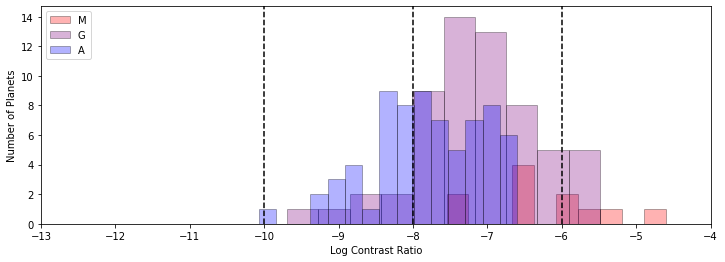

In [42]:
fig, ax = plt.subplots(figsize=(12,4))
hist, edges, patches = ax.hist(logCRM, facecolor=(1, 0, 0), ec='k', alpha=0.3, label='M')
#hist, edges, patches = ax.hist(logCRK, bins=25, facecolor=(0.15,0.6,0.72), ec='k', alpha=0.3, label='K')
hist, edges, patches = ax.hist(logCRG, facecolor=(0.5,0.0,0.5), ec='k', alpha=0.3, label='G')
#hist, edges, patches = ax.hist(logCRF, bins=15, facecolor=(0.45,0.38,0.36), ec='k', alpha=0.3, label='F')
hist, edges, patches = ax.hist(logCRA, bins=15, facecolor=(0.0,0.0,1), ec='k', alpha=0.3, label='A')


ax.axvline(-6, color='k', linestyle='--')
ax.axvline(-8, color='k', linestyle='--')
ax.axvline(-10, color='k', linestyle='--')

#hist, edges, patches = ax.hist(logCRscat0001)
#ax.fill_betweenx([0, 300], -6, -4, facecolor='m', alpha=0.3)
#|ax.set_ylim([0, 250])
ax.legend(loc=2)
ax.set_xlim([-13, -4])
ax.set_xlabel('Log Contrast Ratio')
ax.set_ylabel('Number of Planets')

/home/roikku/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/home/roikku/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


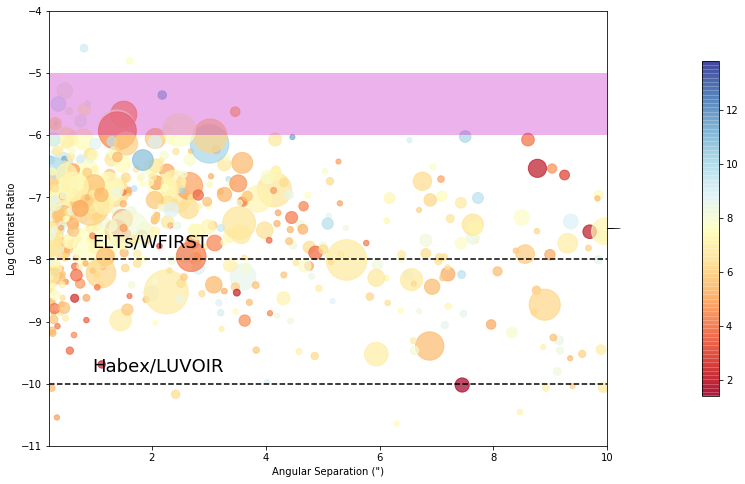

In [68]:
mask = (~np.isnan(CR)) & (a/d > 0.2) & (a/d < 10)
cm = plt.cm.get_cmap('RdYlBu')

sep = a[mask]/d[mask]
logCR = np.log10(CR[mask])
Imag2 = Imag[mask]
#Imag2 = a[mask]/50.
Mpltcut = Mplt[mask]
color_flags = [False, False, False, False, False, False]
fig, axarr = plt.subplots(figsize=(12,8), ncols=2, gridspec_kw = {'width_ratios':[5, 1]}, sharey=True)
sc = axarr[0].scatter(sep, logCR, c=Imag2, s=400*Mpltcut/MEARTH/318, cmap=cm, alpha=0.7)
# for i in range(len(sep)):
#     if star_type[i] == 'M':
#         if color_flags[0]:
#             axarr[0].scatter(sep[i], logCR[i], c=(1, 0, 0), s=400*Mpltcut[i]/Mearth/318, alpha=0.4)
#         else:
#             axarr[0].scatter(sep[i], logCR[i], c=(1, 0, 0), s=400*Mpltcut[i]/Mearth/318, alpha=0.4, label="M")
#             color_flags[0] = True
    
#     elif star_type[i] == 'K':
#         if color_flags[1]:
#             axarr[0].scatter(sep[i], logCR[i], c=(80/100, 0, 20/100), s=400*Mpltcut[i]/Mearth/318, alpha=0.4)
#         else:
#             axarr[0].scatter(sep[i], logCR[i], c=(80/100, 0, 20/100), s=400*Mpltcut[i]/Mearth/318, alpha=0.4, label="K")
#             color_flags[1] = True
    
#     elif star_type[i] == 'G':
#         if color_flags[2]:
#             axarr[0].scatter(sep[i], logCR[i], c=(60/100, 0, 40/100), s=400*Mpltcut[i]/Mearth/318, alpha=0.4)
#         else:
#             axarr[0].scatter(sep[i], logCR[i], c=(60/100, 0, 40/100), s=400*Mpltcut[i]/Mearth/318, alpha=0.4, label="G")
#             color_flags[2] = True
            
#     elif star_type[i] == 'F':
#         if color_flags[3]:
#             axarr[0].scatter(sep[i], logCR[i], c=(40/100, 0, 60/100), s=400*Mpltcut[i]/Mearth/318, alpha=0.4)
#         else:
#             axarr[0].scatter(sep[i], logCR[i], c=(40/100, 0, 60/100), s=400*Mpltcut[i]/Mearth/318, alpha=0.4, label="F")
#             color_flags[3] = True
    
#     elif star_type[i] == 'B':
#         if color_flags[4]:
#             axarr[0].scatter(sep[i], logCR[i], c=(20/100, 0, 80/100), s=400*Mpltcut[i]/Mearth/318, alpha=0.4)
#         else:
#             axarr[0].scatter(sep[i], logCR[i], c=(20/100, 0, 80/100), s=400*Mpltcut[i]/Mearth/318, alpha=0.4, label="B")
#             color_flags[4] = True
            
#     elif star_type[i] == 'A':
#         if color_flags[5]:
#             axarr[0].scatter(sep[i], logCR[i], c=(0, 0, 1), s=400*Mpltcut[i]/Mearth/318, alpha=0.4)
#         else:
#             axarr[0].scatter(sep[i], logCR[i], c=(0, 0, 1), s=400*Mpltcut[i]/Mearth/318, alpha=0.4, label="A")
#             color_flags[5] = True
            
axarr[0].fill_between(np.linspace(0.2, 10, 10), -6, -5, facecolor='m', alpha=0.3)
#axarr[0].plot(contrastsep, np.log10(contrast/5), 'r-')
axarr[0].axhline(-8, color='k', linestyle='--')
axarr[0].axhline(-10, color='k', linestyle='--')
axarr[0].set_xlim([0.2, 10])
axarr[0].set_ylim([-11, -4])
axarr[0].set_xlabel('Angular Separation (")')
axarr[0].set_ylabel('Log Contrast Ratio')
#axarr[0].set_title('Colormap a_pl/a_opt', fontsize=22)
plt.subplots_adjust(wspace=0)
axarr[0].text(.95, -7.8, "ELTs/WFIRST", color='k', fontsize=18)
axarr[0].text(.95, -9.8, "Habex/LUVOIR", color='k', fontsize=18)
#axarr[0].text(0.75, -7.8, "30-m Class Contrast Target", color='k', fontsize=18)
#axarr[0].legend(ncol=2)
plt.colorbar(sc)
axarr[1].set_axis_off()
vals, bins, patches = axarr[1].hist(np.log10(CR[mask]), orientation='horizontal', bins=20, facecolor='b', ec='k', alpha=0.3)
fig.savefig('GPIproposaldetections.pdf', bbox_inches='tight')

In [49]:
starsM = []
starsT = []
starsL = []
starsd = []
for star in stars:
    if star is not None:
        starsM.append(star.M)
        starsT.append(star.T)
        starsL.append(star.L)
        starsd.append(star.d)

print("{0:.3e} Msun".format(sum(starsM)/len(starsM)/MSUN))
print("{0:.3e} C".format(sum(starsT)/len(starsT)))
print("{0:.3e} Lsun".format(sum(starsL)/len(starsL)/LSUN))
print("{0:.3e} pc".format(sum(starsd)/len(starsd)/PC))

1.283e+00 Msun
4.724e+03 C
1.615e+01 Lsun
6.199e+01 pc


In [52]:
meanStar = swarms.Star(L=1.615e1 * LSUN, M=1.283 * MSUN, T=4724, d=62 * PC)
print(meanStar.Imag)

4.97673514525
